In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df=pd.read_csv('C:/Users/mgika/Documents/KK_Data_analyst/product/RFM_ht_data.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [4]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['CustomerCode']=df['CustomerCode'].astype(str)
df['InvoiceNo']=df['InvoiceNo'].astype(str)

In [5]:
last_date=df['InvoiceDate'].max()

In [6]:
df

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


In [7]:
# Какое максимальное кол-во покупок было совершено одним пользователем?

df.groupby('CustomerCode').agg({'InvoiceNo':'count'}).sort_values('InvoiceNo', ascending=False).head()

,InvoiceNo
CustomerCode,
19057820,204
13215452,113
13032521,106
19080880,99
99003061,90


In [11]:
# Создаём RFM-таблицу

rfm_table=df.groupby('CustomerCode',as_index=False).agg({'InvoiceDate':lambda x: (last_date-x.max()).days,
                                         'InvoiceNo':lambda x:len(x),
                                         'Amount':lambda x:x.sum()})


rfm_table['InvoiceDate'] = rfm_table['InvoiceDate'].astype(int)


rfm_table=rfm_table.rename(columns={'InvoiceDate':'recency',
                         'InvoiceNo':'frequency',
                         'Amount':'monetary_value'})

rfm_table

,CustomerCode,recency,frequency,monetary_value
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [12]:
rfm_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123733 entries, 0 to 123732
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerCode    123733 non-null  object 
 1   recency         123733 non-null  int32  
 2   frequency       123733 non-null  int64  
 3   monetary_value  123733 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 3.3+ MB


In [13]:
# Рассчитаем квантили

quantiles=rfm_table.quantile(q=(0.25,0.5,0.75))
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [ ]:
# Разобьём пользователей на классы

In [14]:
def Rclass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.5]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]:
        return 3
    else:
        return 4

In [15]:
def FMclass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.5]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]:
        return 2
    else:
        return 1

In [16]:
rfm_segmentation=rfm_table

In [17]:
rfm_segmentation['R_quantile']=rfm_segmentation['recency'].apply(Rclass,args=('recency', quantiles))
rfm_segmentation['F_quantile']=rfm_segmentation['frequency'].apply(FMclass,args=('frequency', quantiles))
rfm_segmentation['M_quantile']=rfm_segmentation['monetary_value'].apply(FMclass,args=('monetary_value', quantiles))
rfm_segmentation['RFM_class']=rfm_segmentation['R_quantile'].map(str)\
                             +rfm_segmentation['F_quantile'].map(str)\
                             +rfm_segmentation['M_quantile'].map(str)

In [18]:
rfm_segmentation.head()

,CustomerCode,recency,frequency,monetary_value,R_quantile,F_quantile,M_quantile,RFM_class
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443


In [19]:
# Верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М?

rfm_segmentation.query('M_quantile==4').monetary_value.max()

765.0

In [20]:
# нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F

rfm_segmentation.query('F_quantile==1').frequency.min()

4

In [21]:
# Какое максимальное количество дней может пройти с момента последней покупки для того, 
# чтобы пользователь попал в класс 2 в подсегменте R?

rfm_segmentation.query('R_quantile==2').recency.max()

8

In [22]:
# Сколько пользователей попало в сегмент 111?

rfm_segmentation.query('RFM_class=="111"').CustomerCode.count()
# rfm_segmentation[rfm_segmentation.RFM_class == '111'].shape[0]

9705

In [23]:
# Сколько пользователей попало в сегмент 311?

rfm_segmentation.query('RFM_class=="111"').CustomerCode.count()
# rfm_segmentation[rfm_segmentation.RFM_class == '311'].shape[0]

9705

In [24]:
# В каком RFM-сегменте самое большое кол-во пользователей?

rfm_segmentation.groupby('RFM_class').agg({'CustomerCode':'count'})\
.sort_values('CustomerCode', ascending = False).head()

,CustomerCode
RFM_class,
444,10624
111,9705
443,6729
344,6593
211,5847


In [25]:
# В каком RFM-сегменте самое маленькое кол-во пользователей?
# Какое количество пользователей попало в самый малочисленный сегмент?

rfm_segmentation.groupby('RFM_class').agg({'CustomerCode':'count'})\
.sort_values('CustomerCode').head()

,CustomerCode
RFM_class,
414,2
314,33
114,60
214,60
424,63


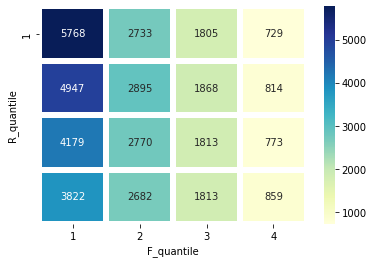

In [28]:
# Heatmap code from KK lecture

rfm_table = rfm_segmentation.pivot_table(
                        index='R_quantile', 
                        columns='F_quantile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);